# PPI power analysis



In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import matplotlib.pyplot as plt
from ppi_py.datasets import load_dataset
from ppi_py.power_ppi import ppi_power, ppi_mean_power, ppi_ols_power, ppi_poisson_power
from ppi_py.ppi import ppi_mean_ci, ppi_ols_ci, ppi_poisson_ci
from scipy.optimize import brentq
from scipy.stats import norm
from utils import *
import warnings
warnings.simplefilter('always', UserWarning)

## Power analysis with known $\tilde{\rho}$

The function `ppi_power` computes an optimal pair of sample sizes given the PPI-correlation $\tilde{\rho}$ [BHvL24], and $\sigma^2$ the asymptotic variance of the classical point estimate. The user must also supply the costs of $Y$, $f(X)$ and $X$. 

The output is a dictionary containing 
* `n` -- the number of labeled samples
* `N` -- the number of unlabeled samples
* `cost` -- the total cost of gathering `n` labeled and `N` unlabed samples and performing PPI
*  `se` -- the standard error of the PPI point estimate with `n` labeled and `N` unlabeled samples
* `rho` -- the user supplied PPI correlation
* `effective_n` -- the *effective sample size* this is the number of labeled samples required for the classical estimate to match the PPI point estimate.

The function `ppi_power` has two options. If `budget` is supplied, then the function will compute the *most powerful pair*. If `se` is supplied, then the function will compute the *cheapest pair*.

### Power analysis for the most powerful pair

When `budget` is supplied, `ppi_power` will compute the pair of sample sizes (`n`, `N`) that minimize the standard error while staying with the given budget.

In [3]:
rho = 0.95
sigma_sq = 1
cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01

budget = 864

optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, budget = budget)
optimal_pair

{'n': 604,
 'N': 12391,
 'cost': 863.9,
 'se': 0.015194526298629673,
 'rho': 0.95,
 'effective_n': 4331}

The below plot shows that the computed pair achieves the lowest standard error subject to the budget constraint. The cost of the pair (`n`, `N`) matches the budget. And, at the point (`n`, `N`) the budget line is tangent to the level curves of the PPI standard error.

C:\Users\micha\AppData\Local\Temp\ipykernel_20460\370605096.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(Ns, ns, ppi_se, label = "standard error")


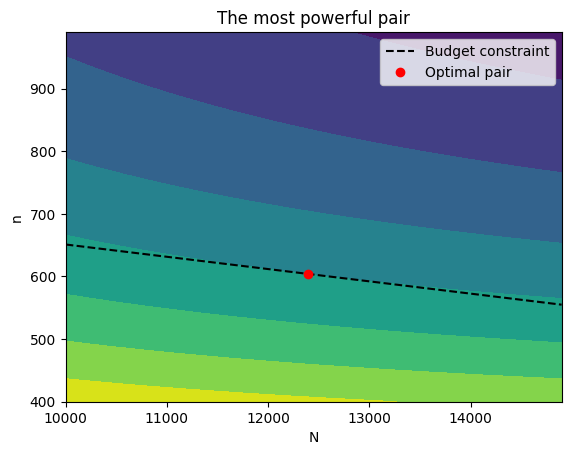

In [4]:
n = np.arange(400, 1000, 10)
N = np.arange(10000, 15000, 100)
ns, Ns = np.meshgrid(n, N)
ppi_se = np.sqrt(sigma_sq/ns * (1 - Ns/(Ns+ns)*rho**2))
plt.contourf(Ns, ns, ppi_se, label = "standard error")
n_cost = (budget - N*(cost_X + cost_Yhat))/(cost_X + cost_Y + cost_Yhat)
plt.plot(N, n_cost, "k--", label = "Budget constraint")

n_opt = optimal_pair['n']
N_opt = optimal_pair['N']

plt.plot(N_opt, n_opt, 'ro', label = "Optimal pair")
plt.legend()
plt.xlabel("N")
plt.ylabel("n")
plt.title("The most powerful pair")
plt.show()

The function `ppi_power` has an optional input called `n_max`. This input should be provided if there is a limit on the total number of samples. When `n_max` is provided, the output will satisfy the additional constraint `n + N <= n_max`.

In [5]:
n_max = 10000
optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, budget = budget, n_max = n_max)
optimal_pair

{'n': 664,
 'N': 9336,
 'cost': 864.0,
 'se': 0.015397641033534665,
 'rho': 0.95,
 'effective_n': 4217}

The following plot shows that the new optimal pair satisfies `n + N <= n_max`.

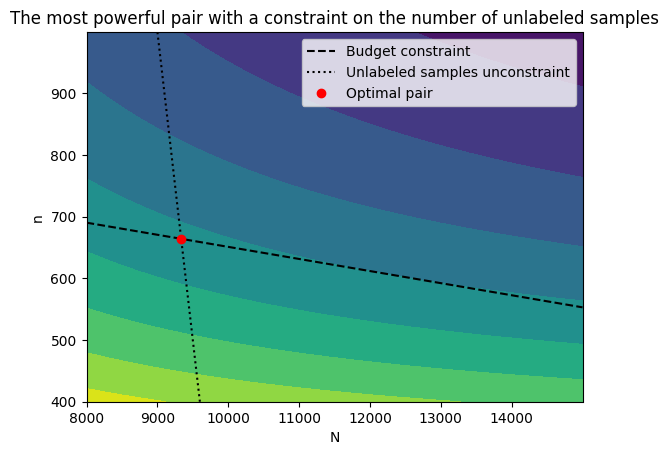

In [6]:
n = np.arange(400, 1000)
N = np.arange(8000, 15000)
ns, Ns = np.meshgrid(n, N)
ppi_se = np.sqrt(sigma_sq/ns * (1 - Ns/(Ns+ns)*rho**2))
plt.contourf(Ns, ns, ppi_se)
n_cost = (budget - N*(cost_X + cost_Yhat))/(cost_X + cost_Y + cost_Yhat)
N_max_constraint = n_max - n


plt.plot(N, n_cost, "k--", label = "Budget constraint")
plt.plot(N_max_constraint, n, "k:", label = "Unlabeled samples unconstraint")

n_opt = optimal_pair['n']
N_opt = optimal_pair['N']

plt.plot(N_opt, n_opt, 'ro', label = "Optimal pair")
plt.legend()
plt.xlabel("N")
plt.ylabel("n")
plt.title("The most powerful pair with a constraint on the number of unlabeled samples")
plt.show()


### Power analysis for the cheapest pair

If the input `se` is provided instead of `budget`, then `ppi_power` will compute the *cheapest pair*. This is the pair (`n`, `N`) that minimizes the cost while achieving a PPI standard error of `se`. 

In [7]:
rho = 0.95
sigma_sq = 1
cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01

se = 0.00975

optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, se = se)
optimal_pair

{'n': 1466,
 'N': 30091,
 'cost': 2097.14,
 'se': 0.009752258528781628,
 'rho': 0.95,
 'effective_n': 10514}

The below plot shows that the computed pair achieves the lowest cost subject to achieving the given standard error. The standard error of the pair (`n`, `N`) matches the desired level `se`. And, at the point (`n`, `N`) the level curve of the standard error is tangent to the level curves of the budget.

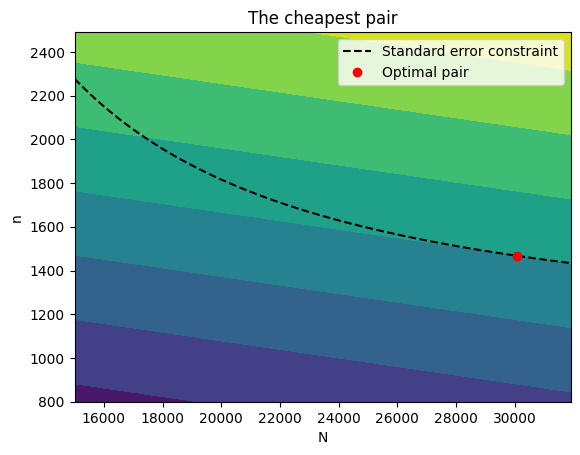

In [8]:
n = np.arange(800, 2500, 10)
N = np.arange(15000, 32000, 100) 
ns, Ns = np.meshgrid(n, N)
costs = ns * (cost_X + cost_Yhat + cost_Y) + Ns * (cost_X + cost_Yhat)
plt.contourf(Ns, ns, costs)

n_se = (-se**2 * N + sigma_sq + (se**4 *N **2 + 2*se**2 * N * sigma_sq - 4 * se**2 * N * rho**2 * sigma_sq + sigma_sq**2)**0.5) /2/se**2
plt.plot(N, n_se, "k--", label = "Standard error constraint")

n_opt = optimal_pair['n']
N_opt = optimal_pair['N']
plt.plot(N_opt, n_opt, 'ro', label = "Optimal pair")
plt.xlabel("N")
plt.ylabel("n")
plt.title("The cheapest pair")
plt.legend()
plt.show()


By providing `n_max` to `ppi_power`, the output will satisfy the additional constraint `n+N <= n_max`.

In [9]:
n_max = 25000
optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, se = se, n_max = n_max)
print(optimal_pair)

{'n': 1653, 'N': 23347, 'cost': 2153.0, 'se': 0.009751085378649191, 'rho': 0.95, 'effective_n': 10517}


C:\Users\micha\AppData\Local\Temp\ipykernel_20460\3708500682.py:1: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(Ns, ns, costs, label = "Costs")


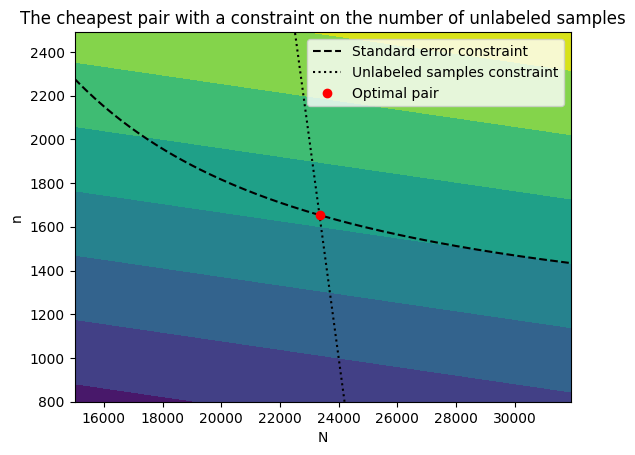

In [10]:
plt.contourf(Ns, ns, costs, label = "Costs")
plt.plot(N, n_se, "k--", label = "Standard error constraint")

N_max_constraint = n_max - n
plt.plot(N_max_constraint, n, "k:", label = "Unlabeled samples constraint")

n_opt = optimal_pair['n']
N_opt = optimal_pair['N']
plt.plot(N_opt, n_opt, 'ro', label = "Optimal pair")
plt.legend()
plt.xlabel("N")
plt.ylabel("n")
plt.title("The cheapest pair with a constraint on the number of unlabeled samples")
plt.show()

It is possible that no pair of sample sizes can achieve the desired `se` and satisfy `n + N <= n_max`. In this case, `ppi_power` will give a warning and return `n = n_max` and `N = 0`. This pair gives the smallest standard error under the constraint `n + N <= n_max`.

In [11]:
n_max = 10000
optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, se = se, n_max = n_max)
print(optimal_pair)

{'n': 10000, 'N': 0, 'cost': 10100.0, 'se': 0.01, 'rho': 0.95, 'effective_n': 10000}


c:\Users\micha\Documents\GitHub\ppi_py\ppi_py\power_ppi.py:268: UserWarning: The desired standard error is too small for the given number of unlabeled samples. 
Returning n = n_max and N = 0. To achieve the desired standard error, increase n_max or decrease se.
  warnings.warn("The desired standard error is too small for the given number of unlabeled samples. \nReturning n = n_max and N = 0. To achieve the desired standard error, increase n_max or decrease se.", UserWarning)


### Computing a desired standard error

The cheapest pair requires the user to provide a desired standard error. In some cases, a researcher will have a desired level of power instead of a desired level of power. To translate the desired level of power, the researcher must supply a desired effectsize $\delta = \theta_1 - \theta_0$ and a level of type 1 error $\alpha$. To achieve the type 1 error $\alpha$ and a type 2 error of $\beta$ with the effectsize $\delta$, the desired standard error $s$ is given by solving 

$$ P(|\delta/s + Z| > z_{1-\alpha/2}) = 1-\beta,$$

where $Z \sim \mathcal{N}(0,1)$ and $z_{1-\alpha/2}$ is the $1-\alpha/2$ quantile of the normal distribution. The function `se_from_power` computes the desired standard error given `effect_size` ($\delta$), `power` ($1-\beta$) and `level` ($\alpha$).

In [12]:
from scipy.stats import norm, foldnorm
from scipy.optimize import brentq

def se_from_power(effect_size, power, level = 0.05):
    assert 0 < power < 1, "Power must be between 0 and 1"
    assert 0 < level < 1, "Level must be between 0 and 1"
    assert 0 != effect_size, "Effect size must be non-zero"
    assert power > level, "Power must be greater than level"
    q = norm.ppf(1 - level/2)
    beta = 1 - power
    def f(s):
        return foldnorm.cdf(q, c = effect_size/s) - beta
    b = np.abs(effect_size)/(q - norm.ppf(beta))/2
    a = b*2
    while f(a) < 0:
        a = a*2


    se = brentq(f, a, b)
    return se

The function `se_from_power` can be used to compute the cheapest pair achieving a given level of power.

In [13]:
level = 0.05
power = 0.8
effect_size = 0.1
se = se_from_power(effect_size, power, level)

optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, se = se)
print(optimal_pair)


{'n': 109, 'N': 2245, 'cost': 156.07999999999998, 'se': 0.03574752281425255, 'rho': 0.95, 'effective_n': 782}


## Power analysis for the mean

In general $\tilde{\rho}$ and $\sigma^2$ have to be estimated from data. The functions `ppi_<estimator>_power` estimate these parameters for different PPI estimators and then compute the optimal pair. 

The following example performs a power analysis for estimating the mean using the `ballots` dataset from *Angelopoulos et al (2023)*. A random subsample of $n=500$ labeled points and $N=500$ unlabeled points is used to estimate $\tilde{\rho}$ and $\sigma^2$. The output is a dictionary with the same entries as before.

By providing costs and a budget, `ppi_mean_power` computes the most powerful pair for the mean.

In [14]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "ballots")
Y = data["Y"]
Yhat = data["Yhat"]
Yhat_unlabeled = data["Yhat_unlabeled"]

n = Y.shape[0]
N = Yhat_unlabeled.shape[0]

n_initial = 500
N_initial = 500

labeled_initial = np.random.choice(n, n_initial, replace = False)
unlabeled_initial = np.random.choice(N, N_initial, replace = False)

Y_initial = Y[labeled_initial]
Yhat_initial = Yhat[labeled_initial]
Yhat_unlabeled_initial = Yhat_unlabeled[unlabeled_initial]
cost_Y = 1
cost_Yhat = 0.01

most_powerful_pair = ppi_mean_power(Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, budget = 1000)
most_powerful_pair

{'n': 710,
 'N': 28273,
 'cost': 999.8299999999999,
 'se': np.float64(0.004990945147992246),
 'rho': np.float64(0.9712690671510825),
 'effective_n': 8903}

The functions `ppi_<estimator>_power` can also be used to compute the cheapest pair achieving a desired standard error. This is done by providing costs and the input `se`.

In [15]:
se = 0.01
cheapest_pair = ppi_mean_power(Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, se =  se)
cheapest_pair

{'n': 176,
 'N': 7041,
 'cost': 248.17000000000002,
 'se': np.float64(0.010017797172113846),
 'rho': np.float64(0.9712690671510825),
 'effective_n': 2209}

The functions `ppi_<estimator>_power` also have an optional `n_max` argument. When `n_max` is provided, the output will satisfy `n + N <= n_max`.

In [16]:
n_max = 2500
cheapest_pair_2 = ppi_mean_power(Y_initial, 
                                 Yhat_initial, 
                                 Yhat_unlabeled_initial, 
                                 cost_Y, 
                                 cost_Yhat, 
                                 se =  se, 
                                 n_max = n_max)
cheapest_pair_2

{'n': 769,
 'N': 1731,
 'cost': 794.0,
 'se': np.float64(0.010000991688972314),
 'rho': np.float64(0.9712690671510825),
 'effective_n': 2217}

The data driven power analysis is subject to estimation error in $\tilde{\rho}$ and $\sigma^2$. To illustrate this, we take the sample sizes from `most_powerful_pair` and generate multiple samples of the given size. We run PPI on each sample and compute the standard error. The histogram compares the predicted standard error to the observed standard errors.

In [17]:
n_opt = most_powerful_pair['n']
N_opt = most_powerful_pair['N']

n = Y.shape[0]
N = Yhat_unlabeled.shape[0]
reps = 200 
ses = np.zeros(reps)
for i in range(reps):
    labeled_sample = np.random.choice(n, n_opt, replace = False)
    unlabeled_sample = np.random.choice(N, N_opt, replace = False)

    Y_opt = Y[labeled_sample]
    Yhat_opt = Yhat[labeled_sample]
    Yhat_unlabeled_opt = Yhat_unlabeled[unlabeled_sample]
    CI = ppi_mean_ci(Y_opt, Yhat_opt, Yhat_unlabeled_opt, alpha = 0.05)
    ses[i] = (CI[1][0] - CI[0][0])/norm.ppf(1 - 0.05/2)/2

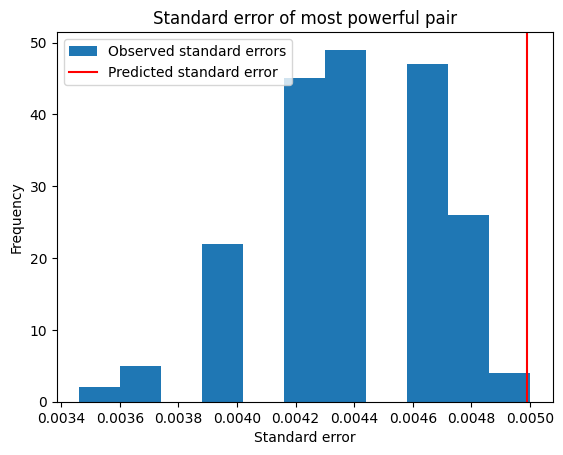

In [18]:
plt.hist(ses, bins = 11, label="Observed standard errors")
plt.axvline(most_powerful_pair['se'], color = 'red', label = "Predicted standard error")
plt.title("Standard error of most powerful pair")
plt.xlabel("Standard error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

One way to quantify the estimation uncertainty in estimating $\tilde{\rho}$ and $\sigma^2$ is to perform the bootstrap on the initial datasets and perform a power analysis on each bootstrap resample. This will give a range of plausible values of $\tilde{\rho}$ and a range of optimal sample sizes.

## Power analysis for linear regression

The function `ppi_ols_power` performs a data-driven power analysis for linear regression. This is illustrated using the `census_income` dataset from *Angelopolous et al (2023)*.


In [19]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500
N_initial = 500

sample = np.random.choice(n_total, n_initial + N_initial, replace = False)
Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]

cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01
coord = 0
se = 50

cheapest_pair = ppi_ols_power(X_initial, 
                                   Y_initial, 
                                   Yhat_initial,
                                   X_unlabeled_initial,
                                   Yhat_unlabeled_initial, 
                                   cost_Y, 
                                   cost_Yhat, 
                                   cost_X,
                                   coord,
                                   se = se)
cheapest_pair

{'n': 1739,
 'N': 5333,
 'cost': 1880.44,
 'se': np.float64(50.002263364222316),
 'rho': np.float64(0.49855450572834303),
 'effective_n': 2140}

Again we can compare the estimated standard error to the observed standard error from subsampling the data.

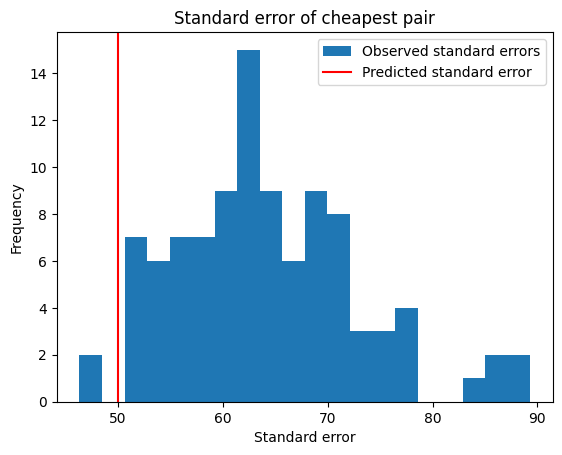

In [20]:
n_opt = cheapest_pair['n']
N_opt = cheapest_pair['N']

reps = 100
ses = np.zeros(reps)
for i in range(reps):
    sample = np.random.choice(n_total, n_opt + N_opt, replace = False)
    Y_opt = Y_total[sample[:n_opt]]
    Yhat_opt = Yhat_total[sample[:n_opt]]
    X_opt = X_total[sample[:n_opt]]
    Yhat_unlabeled_opt = Yhat_total[sample[n_opt:]]
    X_unlabeled_opt = X_total[sample[n_opt:]]

    CI = ppi_ols_ci(X_opt, Y_opt, Yhat_opt, X_unlabeled_opt, Yhat_unlabeled_opt, alpha = 0.05, coord = coord)
    ses[i] = (CI[1][coord] - CI[0][coord])/norm.ppf(1 - 0.05/2)/2
    
plt.hist(ses, bins = 20, label = "Observed standard errors")
plt.axvline(cheapest_pair['se'], color = 'red', label = "Predicted standard error")
plt.xlabel("Standard error")
plt.ylabel("Frequency")
plt.title("Standard error of cheapest pair")
plt.legend()
plt.show()    

## Poisson regression power analysis

Next we perform a power analysiss for a Poisson regression problem with `ppi_poisson_power`. This is done with the `census_income` dataset from *Angelopolous et al (2023)*.


In [21]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_education")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]/10000 # scale

n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500
N_initial = 500

sample = np.random.choice(n_total, n_initial + N_initial, replace = False)

Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]

cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01
coord = 0

most_powerful_pair = ppi_poisson_power(X_initial, 
                                       Y_initial, 
                                       Yhat_initial,
                                       X_unlabeled_initial,
                                       Yhat_unlabeled_initial, 
                                       cost_Y, 
                                       cost_Yhat, 
                                       cost_X,
                                       coord,
                                       budget = 5000)
most_powerful_pair

{'n': 4406,
 'N': 25247,
 'cost': 4999.06,
 'se': np.float64(59.39933217928721),
 'rho': np.float64(0.6893760288048048),
 'effective_n': 7400}

In [22]:
cheapest_pair = ppi_poisson_power(X_initial, 
                                Y_initial, 
                                Yhat_initial,
                                X_unlabeled_initial,
                                Yhat_unlabeled_initial, 
                                cost_Y, 
                                cost_Yhat, 
                                cost_X,
                                coord,
                                se = 30)
cheapest_pair

{'n': 17273,
 'N': 98960,
 'cost': 19597.66,
 'se': np.float64(30.0001638740093),
 'rho': np.float64(0.6893760288048048),
 'effective_n': 29011}

In [23]:
n_opt = most_powerful_pair['n']
N_opt = most_powerful_pair['N']

reps = 100
ses = np.zeros(reps)
for i in range(reps):
    sample = np.random.choice(n_total, n_opt + N_opt, replace = False)
    Y_opt = Y_total[sample[:n_opt]]
    Yhat_opt = Yhat_total[sample[:n_opt]]
    X_opt = X_total[sample[:n_opt]]
    Yhat_unlabeled_opt = Yhat_total[sample[n_opt:]]
    X_unlabeled_opt = X_total[sample[n_opt:]]

    CI = ppi_poisson_ci(X_opt, Y_opt, Yhat_opt, X_unlabeled_opt, Yhat_unlabeled_opt, alpha = 0.05, coord = coord)
    ses[i] = (CI[1][coord] - CI[0][coord])/norm.ppf(1 - 0.05/2)/2
    
    

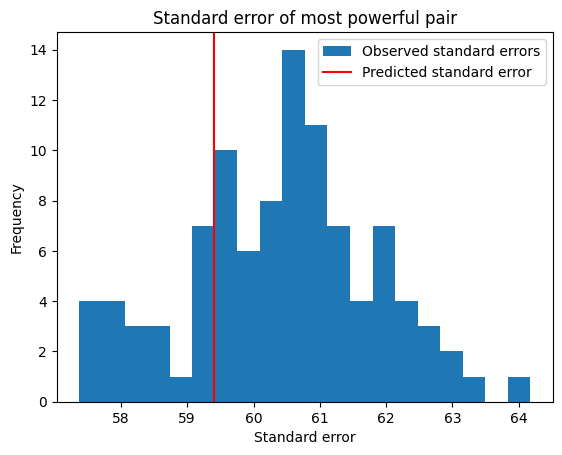

In [24]:
plt.hist(ses, bins = 20, label="Observed standard errors")
plt.axvline(most_powerful_pair['se'], color = 'red', label = "Predicted standard error")
plt.legend()
plt.title("Standard error of most powerful pair")
plt.xlabel("Standard error")
plt.ylabel("Frequency")
plt.show()